# Code Challenge : ICX Media

__Aim of Challenge__ : The aim or task of this coding challenge is to create a pipeline from clusterring to classification. We use unlabeled dataset and utilise unsupervised clustering algorithm to label the data and then apply supervised classification models on the dateset

## Data Set : Online Rental Dataset

For this task I am using Online Rental Data set from UCI machine learning algorithm

https://archive.ics.uci.edu/ml/datasets/Online+Retail

The Dataset consists of the purchasing transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers. The aim here would be to first segment customers in groups using clustering to obtain labels and then apply classification algorithm.

This dataset is interesting because it gives me some scope of applying many pre processing steps such as handing missing values, outlier detection, balancing unbalanced data etc. It also gives me a scope to apply some creative feature engineering for the customer segmentation.

Let us start by loading the libraries that we will need for this task

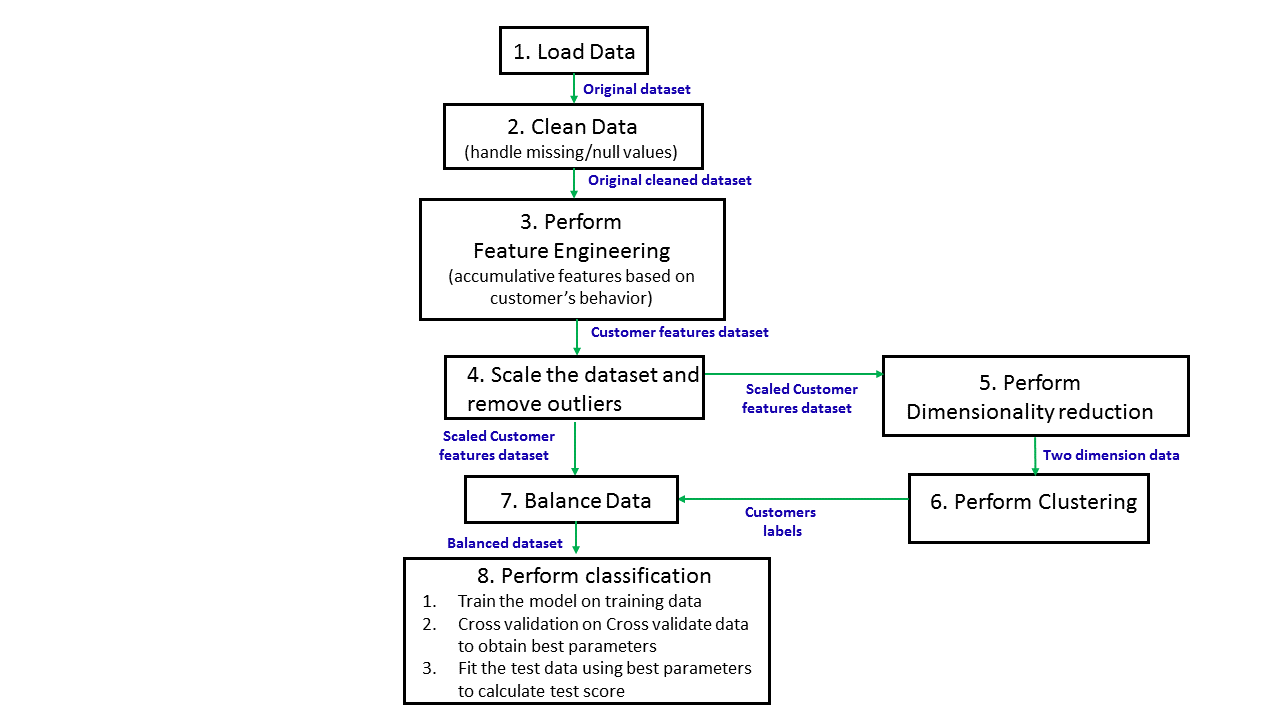

In [1]:
from IPython.display import Image
Image("img/schema.png")

In [2]:
import pandas as pd
import numpy as np

#Libraries for visualisation and plotting
import pylab
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

#Library for basic EDA and preprocessing
from scipy import stats
from sklearn import preprocessing
import sklearn

#Library for Dimension Reduction
from sklearn.decomposition import PCA

#Libraries for Unsupervised Machine learning 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.cluster import DBSCAN

#Libraries for Supervised Machine learning models
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors

#Library for hyperparameter tuning of the supervised machine learning models
from sklearn.model_selection import GridSearchCV

#Library for the performance evaluation of the supervised machine learning models
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Increasing the font size of all plots
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

# 1. Loading of Data

In [4]:
data = pd.read_csv('Online Retail.csv')

In [5]:
data.head() # visualise how the data looks like by printing the first five rows of the dataframe.

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Structure of the Dataset

In [6]:
rows = data.shape[0] # number of rows
columns = data.shape[1] # number of columns

In [7]:
print('The data consists of {} rows and {} columns' .format(rows,columns))

The data consists of 541909 rows and 8 columns


## 2) Cleaning the Data

### a) Null values or Missing values

Let us try to see if there are any missing values in the dataset using __isnull()__ function

In [8]:
data.isnull().values.any()

True

True indicates there are missing values/null values. Now lets try to find out which fields have missing values and how many

The __.info__ function gives a piece of overall information about the fields in the dataframe. 

<li>This function gives information about the field names, the data type of each field. 
<li>It also indicates how many null values are there in each field.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


We see that there are many missing values in the column Customer ID as well as some values are missing in Description. Alternatively, __data.isnull().sum()__ function can also be used to calculate the number of missing values in each field

Usually for handling missing values we use __imputation techniques__ such as replacing the missing value with the mean value for numerical type features or replacing my most common value (mode) for categorical features. But here we cannot do this for customerID as many values are missing and it cannot be just for one customer. Therefore, let's drop the rows where custumerID is null.

In [10]:
data.dropna(subset=['CustomerID'],how='all',inplace=True)

Let's check once if we have filled all the missing values

In [11]:
data.isnull().values.any()

False

### b) Statistics on numerical fields

Before we study the statistics of the features, we notice that custumerID is actually a categorical field (object data type) and not a numerical field (int or float datatype). Therefore I am changing the data type of this field to "categorical"

In [12]:
data['CustomerID'] = data['CustomerID'].astype('object')

Let us find us some mean, std, etc of the fields which are numerical (int or float datatype)

In [13]:
data.describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


__Explationation of terms__
<li> Count : Total number of data points
<li> mean : Average value of the field
<li> std : Standard devation of the field
<li> min : Minimum value of the field
<li> 25% : 25th percentile of the field
<li> 50% : 50th percentile of the field
<li> 75% : 75th percentile of the field
<li> max : Maximum value of the field

#### Some key Findings
<br>

<li> We see that the mean of Quantity of single product for a given invoice is about 12.06. Whereas the maximum value is 80995. This clearly indicates the <strong>presence of outliers</strong> in this column.
<li> We also notice that the 75% percentile of quantity is 12. This means that 75% of the products had a quantity less than 12 per invoice. Whereas the mean of this field is 12.06 clearly indicating a <strong>right skewed distribution</strong> affected by outliers. The <strong>median will give a better central tendency</strong> of this distribution as it is less affected by the outliers
<li> Similarly, we see outliers in UnitPrice as mean is 3.46 and max is 38970.


We have noticed some negative values in the Quantity, most probably this indicates canceled transactions. Lets try to print them.

In [14]:
# Creating a mask of rows containing negative quantities
Mask = data[data['Quantity']<0]
Mask.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,12/1/2010 10:24,3.45,17548,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,12/1/2010 10:24,1.65,17548,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,12/1/2010 10:24,1.65,17548,United Kingdom
939,C536506,22960,JAM MAKING SET WITH JARS,-6,12/1/2010 12:38,4.25,17897,United Kingdom


We will remove this canceled transactions

In [15]:
#remove canceled orders
data = data[data['Quantity']>0]

Let us also try to plot the distribution of quantity to visualise the right skewed distribution

No handles with labels found to put in legend.


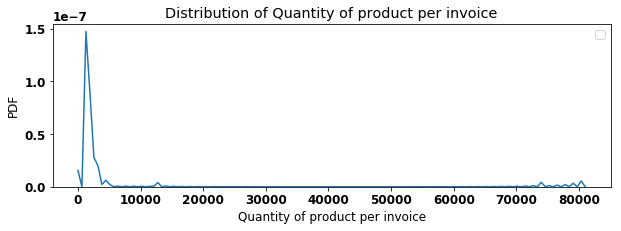

In [16]:
plt.figure(figsize=(10,3))
sns.distplot(data['Quantity'], hist=False)
plt.title('Distribution of Quantity of product per invoice')
plt.xlabel('Quantity of product per invoice')
plt.ylabel('PDF')
plt.legend()
plt.show()

As we observed before, we see that the distribution of quantity is right skewed with majority of quantity being less in value

### c) Statistics on categorical fields

In [17]:
data.describe(include=['object'])

,InvoiceNo,StockCode,Description,InvoiceDate,CustomerID,Country
count,397924,397924,397924,397924,397924.0,397924
unique,18536,3665,3877,17286,4339.0,37
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,11/14/2011 15:27,17841.0,United Kingdom
freq,542,2035,2028,542,7847.0,354345


__Explationation of terms__
<li> Count : Total number of data points
<li> Unique : Number of unique values in each field
<li> top : The most frequent value in the field
<li> freq : The number of times the most frequent or top value appears in the field

#### Some key Findings
<br>

<li> There are 18536 unique invoices and 3665 unique products.
<li> "WHITE HANGING HEART T-LIGHT HOLDER" is the most bought product. 
<li> The data consists of mostly customers from UK

In [18]:
#restricting the data to one full year 
data = data[data['InvoiceDate']>= "2010-12-09"]
data.shape

(199198, 8)

# 3. Feature Engineering

To be able to get a good customer segmentation, we will need to create many new features from the given features. As it has been pointed out in the description of the dataset that some of the customers are actually whole salers we can create some accumulative features which can differentiate a normal everyday customer from a whole saler.

A wholesaler would have a higher mean quality of products per purchase and as a result, the cost per purchase would also be higher. Keeping this as inspiration lets proceed to make some new features.

Lets first find out the cost of each product per invoice. This is just a multiplication of unit price with the quantity of product

In [19]:
# Total cost of a product in a given invoice
data['Cost_per_product'] = data['Quantity'] * data['UnitPrice']

The total cost per invoice would be the some of costs of all products in the given invoice. Similary, the quantity per invoice would be sum of all product's quantity for a given invoice.

In [20]:
# Total cost per invoice
data['Cost_per_invoice']=data.groupby(['InvoiceNo']).Cost_per_product.transform('sum')
# Total qualtity per invoice
data['Quantity_per_invoice']=data.groupby(['InvoiceNo']).Quantity.transform('sum')

In [21]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cost_per_product,Cost_per_invoice,Quantity_per_invoice
105335,545220,21955,DOORMAT UNION JACK GUNS AND ROSES,2,3/1/2011 8:30,7.95,14620,United Kingdom,15.90,235.35,73
105336,545220,48194,DOORMAT HEARTS,2,3/1/2011 8:30,7.95,14620,United Kingdom,15.90,235.35,73
105337,545220,22556,PLASTERS IN TIN CIRCUS PARADE,12,3/1/2011 8:30,1.65,14620,United Kingdom,19.80,235.35,73
105338,545220,22139,RETROSPOT TEA SET CERAMIC 11 PC,3,3/1/2011 8:30,4.95,14620,United Kingdom,14.85,235.35,73
105339,545220,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,4,3/1/2011 8:30,3.75,14620,United Kingdom,15.00,235.35,73


Now we have to create some features such as on average how much quantity does the customer purchases in one purchase. Before we do that, since we have already accumulated features based on the invoice number, let's delete the duplicates over the invoice no and keep only the first row

In [22]:
# Dropping duplicates over the invoice no and keep only the first row
data= data.drop_duplicates(subset={"InvoiceNo"},keep='first')
data.shape

(9786, 11)

Now lets calculate some features for each customer

In [23]:
# Average Quantity of products bought by the custumer per invoice
data['Mean_Quantity']=data.groupby(['CustomerID']).Quantity_per_invoice.transform('median')
# Average Cost spent by the custumer per invoice
data['Mean_Cost']=data.groupby(['CustomerID']).Cost_per_invoice.transform('median')
# Total number of purchases done by the custumer over whole dataset
data['Total_Purchases']=(data.groupby(['CustomerID']).InvoiceNo.transform('nunique'))
# Total Quantity of products bought by the custumer over whole dataset
data['Total_Quantity']=data.groupby(['CustomerID']).Quantity_per_invoice.transform('sum')
# Average Cost spent by products bought by the custumer over whole dataset
data['Total_Cost']=data.groupby(['CustomerID']).Cost_per_invoice.transform('sum')

I would also like to check if there is a lot of variation in the quantity and cost of products that the customer buys for reach purchase. Probably the whole salers would have variation in quantity and cost each time they buy as per their business needs. 

In [24]:
#variation in the quantity of products the custumer buys for each purchase
data['std_Quantity']=data.groupby(['CustomerID']).Quantity_per_invoice.transform('mad')
#variation in the cost of products the custumer buys for each purchase
data['std_Cost']=data.groupby(['CustomerID']).Cost_per_invoice.transform('mad')

In [25]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cost_per_product,Cost_per_invoice,Quantity_per_invoice,Mean_Quantity,Mean_Cost,Total_Purchases,Total_Quantity,Total_Cost,std_Quantity,std_Cost
105335,545220,21955,DOORMAT UNION JACK GUNS AND ROSES,2,3/1/2011 8:30,7.95,14620,United Kingdom,15.9,235.35,73,107.0,206.39,2,214,412.78,34.000000,28.960000
105350,545221,22021,BLUE FELT EASTER EGG BASKET,6,3/1/2011 8:35,1.65,14740,United Kingdom,9.9,521.10,260,251.0,521.10,3,735,1448.21,14.000000,74.224444
105380,545222,22957,SET 3 PAPER VINTAGE CHICK PAPER EGG,6,3/1/2011 8:49,2.95,13880,United Kingdom,17.7,200.10,94,122.0,223.84,9,1263,2193.02,53.037037,64.085185
105389,545223,22487,WHITE WOOD GARDEN PLANT LADDER,4,3/1/2011 8:58,8.50,16462,United Kingdom,34.0,34.00,4,4.0,34.00,3,16,136.00,1.777778,15.111111
105390,545224,22664,TOY TIDY DOLLY GIRL DESIGN,5,3/1/2011 9:03,2.10,17068,United Kingdom,10.5,182.70,86,124.0,206.69,13,1389,2971.54,42.319527,82.080000


Finally lets create a new database of all unique customers along with the above created features

In [26]:
customer = data.drop_duplicates(subset=['CustomerID'])
col = ['CustomerID','Mean_Quantity','Mean_Cost','std_Quantity','Total_Quantity','Total_Cost','std_Cost','Total_Purchases']
customer = customer[col]
customer.head(5)

,CustomerID,Mean_Quantity,Mean_Cost,std_Quantity,Total_Quantity,Total_Cost,std_Cost,Total_Purchases
105335,14620,107.0,206.39,34.000000,214,412.78,28.960000,2
105350,14740,251.0,521.10,14.000000,735,1448.21,74.224444,3
105380,13880,122.0,223.84,53.037037,1263,2193.02,64.085185,9
105389,16462,4.0,34.00,1.777778,16,136.00,15.111111,3
105390,17068,124.0,206.69,42.319527,1389,2971.54,82.080000,13


There would be some customers who would be purchasing just once in the whole dataset, as a result the std of quantity for these customers would be zero. We would remove these customers in order to avoid the bias of the dimensionality reduction method towards these customers.

In [27]:
# removing customers who purchased only once
customer = customer[ (customer['std_Quantity']>0)]

Dropping the customerID feature for further analysis of clustering and classification

In [28]:
customer=customer.drop(['CustomerID'], axis=1)

In [29]:
customer.shape

(1812, 7)

# 4. Scaling of features and outlier removal

### Scaling

Before we perform the dimensionality reduction of the data, we should do the __scaling of the features__.It is important to scale the numerical fields before feeding them into the model, to avoid the dominance of one field over others, in terms of their magnitude. Dimentionality reduction model such as PCA is specially very affected by the non scaled features. I am using standardization to normalise the features

In [30]:
names = customer.columns
index_values = customer.index
# creating scaler with_mean=False in order to avoid negative values. This is because I will use Naive bayes for cliassification which does not accpt negative values
scaler = preprocessing.StandardScaler(with_mean=False)
scaled_customer = scaler.fit_transform(customer)
scaled_customer = pd.DataFrame(scaled_customer, columns=names, index=index_values)
scaled_customer.head()

,Mean_Quantity,Mean_Cost,std_Quantity,Total_Quantity,Total_Cost,std_Cost,Total_Purchases
105335,0.439700,0.565494,0.151546,0.052692,0.055504,0.054539,0.341742
105350,1.031447,1.427776,0.062401,0.180976,0.194732,0.139783,0.512613
105380,0.501341,0.613305,0.236398,0.310983,0.294882,0.120688,1.537839
105389,0.016437,0.093158,0.007924,0.003940,0.018287,0.028458,0.512613
105390,0.509559,0.566316,0.188628,0.342007,0.399565,0.154577,2.221323


### Outlier Removal

As we have noticed above that there are outliers in the features, it is important to remove them otherwise the models  will be affected by them. We use Z score for removing outliers. Any value of Z score > 3 is considered an outlier

In [31]:
z = np.abs(stats.zscore(customer))
customer = customer[(z < 3).all(axis=1)]

# 5. Dimensionality Reduction

### PCA for dimensionality reduction

Now we will use PCA to reduce the dimensionality of data to two in order to apply clustering algorithm

In [32]:
pca = PCA(n_components=2)
X = pca.fit_transform(scaled_customer) 
X = pd.DataFrame({'dim1': X[:, 0], 'dim2': X[:, 1]})
X.shape

(1812, 2)

Let's try and plot the data

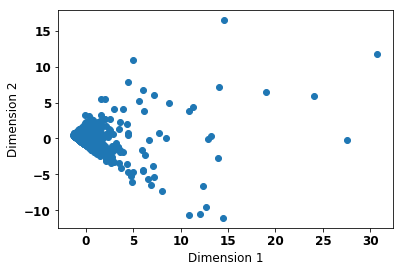

In [33]:
f=plt.figure()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.scatter(X['dim1'],X['dim2'] )
plt.show()

<li> We clearly see a large denser cluster of customers surrounded by not so dense noise kind off clustered data
<li> We already know that <strong>DBSCAN.</strong> (Density-Based Spatial Clustering of Applications with Noise) is great at <strong>separating high density clusters from low density clusters.</strong>
<li> However, lets try to see other clustering methods as well to evaluate there performance

# 6. Clustering

### 6.a) K-means

First, we will use the classical K means algorithm. We will do hyperparameter tuning to find the optimum number of clusters. In order to find out the __optimum number of clusters__ we use __silhouette score__ which indicates how similar an object is to its own cluster compared to other clusters . The higher the silhouette score the better is the clustering.

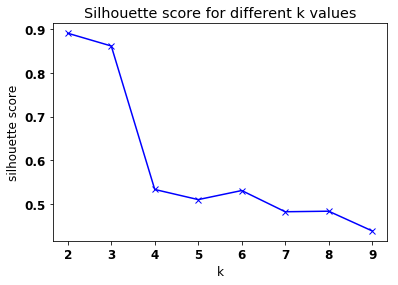

In [34]:
silhouette = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    labels= km.predict(X)
    silhouette.append(silhouette_score(X, labels))

plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette score for different k values')
plt.show()

The highest silhouette score is obtained for K = 2. Lets try to fit the K means for K=2 and plot the clusters

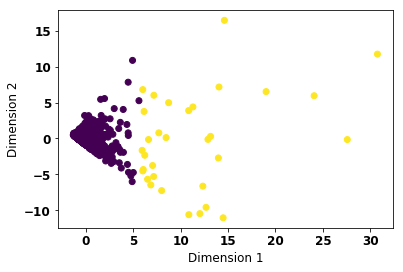

In [35]:
km = KMeans(n_clusters=2)
km = km.fit(X)
kmeans_labels= km.predict(X)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.scatter(X['dim1'],X['dim2'], c=kmeans_labels )

### Disadvantages of K means clustering for this dataset
<br>
<li> K means fails to work clusters of different size and different density therefore we see above that k means is not able to properly differentiate between denser cluster and lesser denser data around
<li> It also favors clusters of globular shape clusters and thus does not produce a good result for this data
<li> It is also severely affected by noisy data which is present in this dataset

Lets try to see another approach which is hierarchical clustering

### 6.b) Hierarchical clustering

Here we will use agglomerative hierarchical clustering.  In this technique, initially each data point is considered as an individual cluster. At each iteration, the similar clusters merge with other clusters until one big cluster is formed.The hierarchical clustering echnique can be visualized using a Dendrogram.
A Dendrogram is a tree-like diagram that records the sequences of merges or splits.

One of the __major disadvantages of hierarchical clustering is its space and time complexity__. The space complexity of this method is of the order O(n^2) where n is the number of data points. Therefore, it cannot be used for data consisting of larger number of data points. Since this dataset does not have large number of data points we can attempt to use this method

There are different ways of calculating inter-cluster distance for hierarchical clustering. Each one of them has its own advantage and disadvantages. Here we are using __ward method which is a compromise between single and complete linkage. It is not susceptible to noise.__

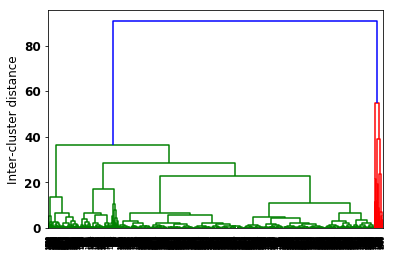

In [36]:
#http://saedsayad.com/clustering_hierarchical.htm
Zd = linkage(X, method="ward")
dn = dendrogram(Zd)
plt.ylabel('Inter-cluster distance')
plt.show()

In the dendrogram  above we clearly see two clusters forming. One is a bigger cluster in green vs a smaller one in red.Therefore if we keep t = 60 ( maximum inter cluster distance allowed) in the fcluster function we should be able to visualize these clusters.

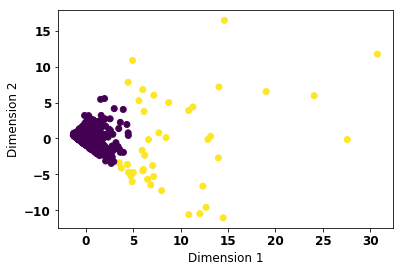

In [37]:
clusters_Hierarchical = fcluster(Zd, 60, criterion='distance')
f=plt.figure()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.scatter(X['dim1'],X['dim2'], c=clusters_Hierarchical)  
plt.show()

### Disdvantages with Hierarchical clustering for this dataset
<br>
<li> Hierarchical clustering performs slightly better than k means for this dataset however we still see some noisy data in the dense cluster. This is because ward method is biased towards globular shapes.



Finally lets try to apply DBSCAN

### 6.c) DBSCAN

In order to apply DBSCAN we need to first perform some hyperparameter tuning to be able to find the optimum epsilon. Usually, a good practice is to set minimum points = log(n) where n is the number of points in the dataset. 

One common practice to find out an __optimum epsilon__ is to use __nearest neighbours__ approach to calculate the distance between points. In a clustering with minimum points = k, we expect that core points and border points' k-distance are within a certain range, while noise points can have much greater k-distance, thus we can observe a knee point in the k-distance plot.

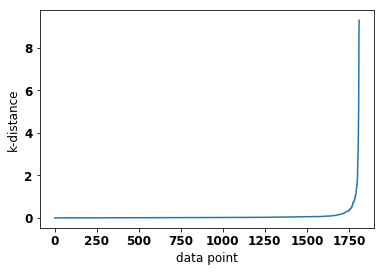

In [38]:
#https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
neigh = NearestNeighbors(n_neighbors=int(np.log(len(X))))
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.ylabel("k-distance")
plt.xlabel("data point")
plt.plot(distances)

Therefore since we observe a knee at about 1, we can keep eps=1 for DBSCAN

In [39]:
dbs = DBSCAN(eps=1, min_samples=int(np.log(len(X)))).fit(X)

Plotting the clusters

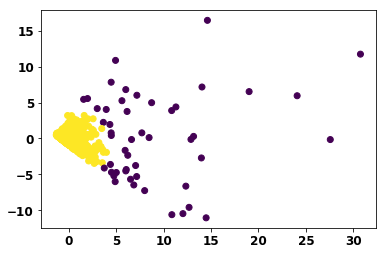

In [40]:
plt.scatter(X['dim1'],X['dim2'], c=dbs.labels_) 

### Reasons for choosing DBSCAN clustering for this dataset
<br>
<li> Unlike K means and hierarchical clustering, DBSCAN is resistant to noise and outliers which is present in this dataset
<li> It can also handle different shapes of clusters and not just globular.
<li> It can separate out a high density cluster from a low density cluster which is present in our dataset.
<li> It does not work very well with high dimensional data but our dataset is not high dimensional
<li> Another major disadvantage of DBSCAN is its sensitivity to its hyper parameters eps and minimum points. However, we have tried to implement some tuning to obtain optimum parameters.



Therefore now we create a new feature "customer_type" and save the labels from DBSCAN clustering in this column

In [41]:
scaled_customer['customer_type']=dbs.labels_
#channging label -1 to 1
scaled_customer['customer_type'] = np.where(scaled_customer['customer_type'] == -1, 1, scaled_customer['customer_type'])
scaled_customer.head()

,Mean_Quantity,Mean_Cost,std_Quantity,Total_Quantity,Total_Cost,std_Cost,Total_Purchases,customer_type
105335,0.439700,0.565494,0.151546,0.052692,0.055504,0.054539,0.341742,0
105350,1.031447,1.427776,0.062401,0.180976,0.194732,0.139783,0.512613,0
105380,0.501341,0.613305,0.236398,0.310983,0.294882,0.120688,1.537839,0
105389,0.016437,0.093158,0.007924,0.003940,0.018287,0.028458,0.512613,0
105390,0.509559,0.566316,0.188628,0.342007,0.399565,0.154577,2.221323,0


# Understanding the clusters using some EDA

Before we go ahead and perform the clustering algorithm, lets try to understand the clusters or segments of customers that we have obtained using some basic EDA

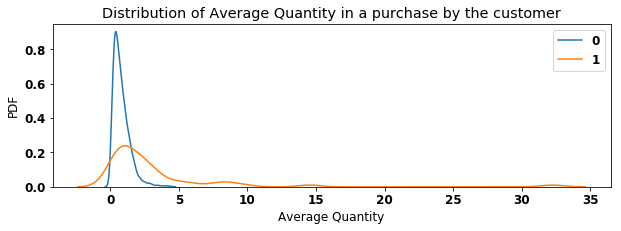

In [42]:
customer_0 = scaled_customer[scaled_customer['customer_type']==0]['Mean_Quantity'].values # values of mean quantity for customers in cluster 0

customer_1 = scaled_customer[scaled_customer['customer_type']==1]['std_Cost'].values # values of mean quantity for customers in cluster 1

plt.figure(figsize=(10,3))
sns.distplot(customer_0, hist=False, label="0")
sns.distplot(customer_1, hist=False, label="1")
plt.title('Distribution of Average Quantity in a purchase by the customer')
plt.xlabel('Average Quantity')
plt.ylabel('PDF')
plt.legend()
plt.show()

We see that the customers in cluster 0 purchase on an average less quantity per invoice as compared to customers in cluster 1 which has a more broader distribution

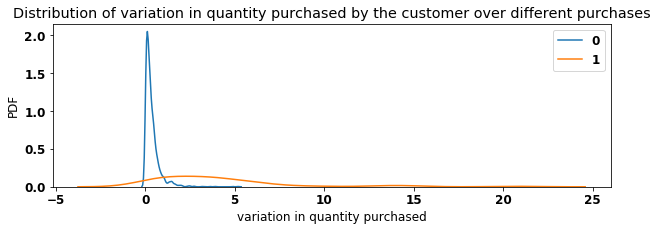

In [43]:
customer_0 = scaled_customer[scaled_customer['customer_type']==0]['std_Quantity'].values # values of variation in the quantity per invoice for customers in cluster 0

customer_1 = scaled_customer[scaled_customer['customer_type']==1]['std_Quantity'].values # values of variation in the quantity per invoice for customers in cluster 1

plt.figure(figsize=(10,3))
sns.distplot(customer_0, hist=False, label="0")
sns.distplot(customer_1, hist=False, label="1")
plt.title('Distribution of variation in quantity purchased by the customer over different purchases')
plt.xlabel('variation in quantity purchased')
plt.ylabel('PDF')
plt.legend()
plt.show()

We clearly see that customers in cluster 0 have a less variation which means that they buy more or less same number of products in each purchase as comapred to customers in cluster 1

Similarly lets check another quantity

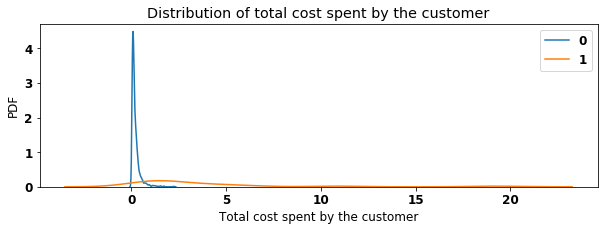

In [44]:
customer_0 = scaled_customer[scaled_customer['customer_type']==0]['Total_Cost'].values # values of Total cost spent for customers in cluster 0

customer_1 = scaled_customer[scaled_customer['customer_type']==1]['Total_Cost'].values # values of Total cost spent customers in cluster 1

plt.figure(figsize=(10,3))
sns.distplot(customer_0, hist=False, label="0")
sns.distplot(customer_1, hist=False, label="1")
plt.title('Distribution of total cost spent by the customer')
plt.xlabel('Total cost spent by the customer')
plt.ylabel('PDF')
plt.legend()
plt.show()

More number of customers in cluster 0 spent lesser total amount in purchasing as compared to customers in cluster 1

Therefore we have created clusters of two different types of customers

### Cluster 0
These are the customers who spend on an average lesser amount per purchase. They also buy lesser quantity of products per purchase. They buy more or less same number of products in each purchase. In total, they spent lesser amount in purchasing. These can be the __normal customers__ or the __retailers__ who purchase in fewer quantities

### Cluster 1
These are the customers who spend on an average more amount per purchase. They also buy more quantity of products per purchase. The variation in quantity of purchase is high. In total, they spent more amount on purchasing. These can be the __whole salers__ or the __distributers__ 

# 7. Balancing the data

Lets check how the number of customers are distrbuted in the two : that is if the data is balanced or imbalanced

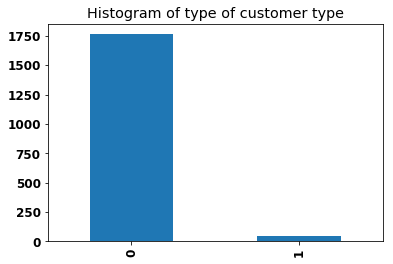

In [45]:
scaled_customer.customer_type.value_counts().plot(kind='bar', title='Histogram of type of customer type');

In [46]:
print("The number of customers in cluster 0: {}" .format(scaled_customer.customer_type.value_counts()[0]))
print("The number of customers in cluster 1: {}" .format(scaled_customer.customer_type.value_counts()[1]))

The number of customers in cluster 0: 1763
The number of customers in cluster 1: 49


We notice that this original dataset is __highly imbalanced__ Most of the custumers belong to cluster 0.<br> 
<br>
<li>Using this dataset for training our model can lead to many errors.
<li>It will create a bias towards the majority class (cluster 0) in our model and can lead to lead to misleading results in some performance matrix.
<li> For example, the typical accuracy score can be very high but that might be just due to predicting all cases as majority class.<br> 

__SMOTE for balancing data__

I will use SMOTE technique to balance the dataset. Since this dataset is already small. Simple random up sampling by simply duplicating the minority class will lead to over fitting. SMOTE on the other hand generates synthetic data and not duplicate data. It will create equal number of minority (cluster 1) data points as there as majority class ( cluster 0)


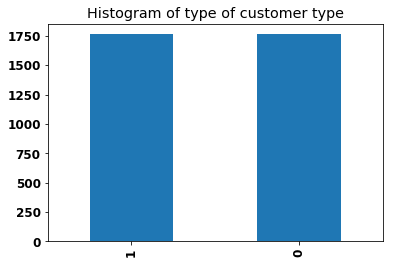

In [47]:
from imblearn.over_sampling import SMOTE

labels = scaled_customer.columns.drop(['customer_type'])

smote = SMOTE(ratio='minority', n_jobs=-1)
X_smote, y_smote = smote.fit_resample(scaled_customer[labels], scaled_customer['customer_type'])

scaled_customer = pd.DataFrame(X_smote, columns=labels)
scaled_customer['customer_type'] = y_smote

scaled_customer.customer_type.value_counts().plot(kind='bar', title='Histogram of type of customer type');

We see that the number of customers in cluster 1 is now equal to the customers in cluster 0.

# 8. Classification

Before we start the classification, let's seperate our target prediction custumer_type from rest of the data.

In [48]:
y = scaled_customer['customer_type']
scaled_customer.drop(['customer_type'], axis=1, inplace=True)
X=scaled_customer

### a) Splitting the data for Training and Test

I am splitting the dataset only in training and test. For cross validation, I will directly perform k fold cross validation using the training data

In [49]:
# Taking one-third of data as test data. 
X_tr, X_test, y_tr, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)

print(X_tr.shape)
print(y_tr.shape)
print(X_test.shape)
print(y_test.shape)

(2468, 7)
(2468,)
(1058, 7)
(1058,)


### b) Fitting the model

__The problem of small dataset and choosing appropriate model for the same__

First of all, to pick the model we should keep in mind that the dataset is fairly __small dataset__. In general, all machine learning perform better with a higher number of data points. With small data, one doesn’t have luxury to keep out many samples for cross validation , therefore the number of observations in cross-validation data may be too few to guide parameter search optimally. This can lead to __overfitting__. Also, the test data points may be too few to give meaningful performance estimate.

One way to handle the small data set is to use __simpler models__. Lesser the degrees of freedom compared to number of training observations, more robust are parameter estimates. Therefore I will prefer simpler models to limit number of parameters to be estimated.

Another way to handle the small data set is to use models which regularise the parameters and help in avoiding overfitting

Keeping this in mind I choose __logistic regression__ as the model for classification task. I will start with a baseline model which I am choosing to be Naive bayes and compare the result of logistic regression with Naive bayes.

Let's start by Naive Bayes as our base model

#### Baseline Model : Naive Bayes

First, we will try to do hyperparameter tuning on the training and cross validation dataset to obtain the best parameter for fitting our model. Both hyper parameter tuning and Cross validation will ensure that we don't overfit or underfit our training data

The best value of AUC = 0.6895460478371992 is given by best alpha = 10000 


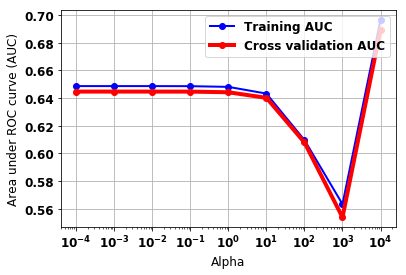

In [50]:
# alpha is laplace smoothing parameter in naive bayes
alpha =[ 0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

# setting parameter grid alpha for hyperparameter tuning using GridsearchCV
param_grid = {'alpha':[ 0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}

# Multinomial Naive Bayes Model
nb = MultinomialNB()

# Setting 3-fold cross validation and hyperparameter tuning using GridSearchCV # We will calculate ROC AUC for training and cross validate 
nb_cv= GridSearchCV(nb,param_grid,cv=3,scoring='roc_auc',return_train_score=True)

# Fitting naive bayes on training data
nb_cv.fit(X_tr,y_tr)

print("The best value of AUC = {} is given by best alpha = {} ".format(nb_cv.best_score_,nb_cv.best_params_.get('alpha')))


train_AUC=nb_cv.cv_results_['mean_train_score'] # Training ROC AUC score

cv_AUC=nb_cv.cv_results_['mean_test_score'] # Cross validate ROC AUC score

#Plotting ROC_AUC
pylab.plot(alpha, train_AUC, '-b', label='Training AUC',linewidth=2.0,marker='o')
pylab.plot(alpha, cv_AUC, '-r', label='Cross validation AUC',linewidth=4.0,marker='o')
pylab.legend(loc='upper right')
pylab.xlabel('Alpha')
pylab.ylabel('Area under ROC curve (AUC)')
pylab.xscale("log")
pylab.grid()
pylab.show()

Now that we have our best parameter. Using that we will fit our training model and then check the score on our test data

__Fitting the model with best parameters and checking the test score__ 

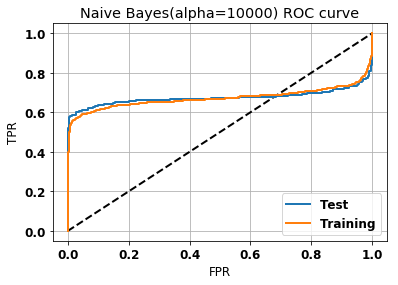

The Training AUC score for hypertuned parameter alpha = 10000 is 0.671874086698388
The Test AUC score for hypertuned parameter alpha = 10000 is 0.6742992992992993


In [51]:
# Fitting the model with best parameters 
nb = MultinomialNB(alpha=nb_cv.best_params_.get('alpha'))
nb.fit(X_tr,y_tr)

# Calculating training and test predicted probabilities
y_pred_proba_test = nb.predict_proba(X_test)[:,1]
y_pred_proba_tr = nb.predict_proba(X_tr)[:,1]

# Calculating False Positive Rate (FPR) and True Positive Rate (TPR) for obtaining ROC curve
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_proba_test)
fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, y_pred_proba_tr)

# Plotting the ROC curve for Test and training data
plt.plot([0,1],[0,1],'k--',linewidth=2.0)
plt.plot(fpr_test,tpr_test, label='Test',linewidth=2.0)
plt.plot(fpr_tr,tpr_tr, label='Training',linewidth=2.0)
plt.xlabel('FPR')
plt.ylabel('TPR')
pylab.legend(loc='lower right')
plt.title('Naive Bayes(alpha={}) ROC curve'.format(nb_cv.best_params_.get('alpha')))
plt.grid()
plt.show()

#Area under ROC curve
print('The Training AUC score for hypertuned parameter alpha = {} is {}'.format(nb_cv.best_params_.get('alpha'),roc_auc_score(y_tr,y_pred_proba_tr)))
print('The Test AUC score for hypertuned parameter alpha = {} is {}'.format(nb_cv.best_params_.get('alpha'),roc_auc_score(y_test,y_pred_proba_test)))

__Confusion Matrix for training data__

Before we plot the confusion matrix we need to find the optimum threshold such that we get a high TPR and low FPR.  We want to keep False Postive as low as possible.

Therefore we define a parameter TF= TPR*(1-FPR) and we try to maximise it while calculating the optimum threshold.

In [52]:
#https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python

i = np.arange(0,len(tpr_tr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr_tr, index=i),'tpr' : pd.Series(tpr_tr, index = i),
                    '1-fpr' : pd.Series(1-fpr_tr, index = i), 'tf' : pd.Series(tpr_tr*(1-fpr_tr), index = i), 
                    'thresholds' : pd.Series(thresholds_tr, index = i)})

roc.ix[(roc.tf-0).abs().argsort()[:1]]

index=roc['tf'].idxmax()

optimim_threshold=roc['thresholds'].iloc[index]
print(roc.iloc[index])
print(optimim_threshold)

fpr           0.044154
tpr           0.588755
1-fpr         0.955846
tf            0.562759
thresholds    0.508598
Name: 72, dtype: float64
0.5085982919273602


Based on the optimum threshold we calculate the predicted probablity

In [53]:
y_pred = (nb.predict_proba(X_tr)[:,1] >= optimim_threshold)*1
# Now we calculate the threshold value
cf=confusion_matrix(y_tr,y_pred)

Plotting the confusion Matrix

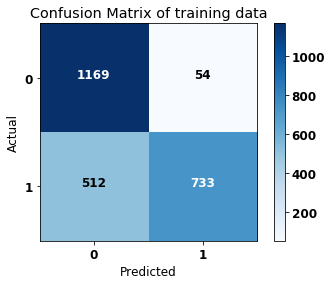

In [54]:
##https://www.kaggle.com/jprakashds/confusion-matrix-in-python-binary-class

plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix of training data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(y_test))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)

# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show();

__Confusion Matrix for test data__

In [55]:
y_pred = (nb.predict_proba(X_test)[:,1] >= optimim_threshold)*1
cf=confusion_matrix(y_test,y_pred)

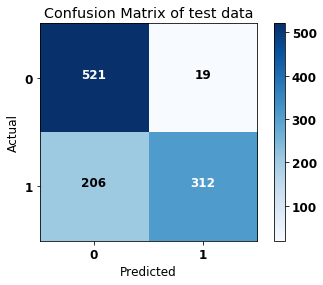

In [56]:
import itertools
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix of test data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(y_test))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show();

__Key Findings on the base Model : Naive Bayes__

<li> The base model gives a training ROC AUC score of 0.738 and the test score is 0.717.
<li> We see that training and test score are comparable. That clearly indicates that we are not overfitting.
<li> If the training score is high and the test score is low that means we have high variance in our model or it is overfitting
<li> If the training score itself is very low that means we have a high bias in our model or it is underfitting.
<li> If we have a look at the confusion matrix for training and test, we have a high TP and FN, which means we don't have bais on majority class caused by imbalanced data
<li> However, we still have some TN and FP , let's see if we can impove it by using Logistic regression.

The best value of AUC = 1.0 is given by best alpha = 0.0001 


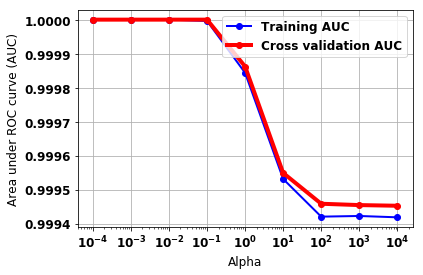

In [57]:
# alpha is regularisation parameter in logistic reg
alpha =[ 0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

# setting parameter grid alpha for hyperparameter tuning using GridsearchCV
param_grid = {'alpha':[ 0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}

# Multinomial Naive Bayes Model
lr = linear_model.SGDClassifier(loss='log')

# Setting 3-fold cross validation and hyperparameter tuning using GridSearchCV # We will calculate ROC AUC for training and cross validate 
lr_cv= GridSearchCV(lr,param_grid,cv=3,scoring='roc_auc',return_train_score=True)

# Fitting naive bayes on training data
lr_cv.fit(X_tr,y_tr)

print("The best value of AUC = {} is given by best alpha = {} ".format(lr_cv.best_score_,lr_cv.best_params_.get('alpha')))


train_AUC=lr_cv.cv_results_['mean_train_score'] # Training ROC AUC score

cv_AUC=lr_cv.cv_results_['mean_test_score'] # Cross validate ROC AUC score

#Plotting ROC_AUC
pylab.plot(alpha, train_AUC, '-b', label='Training AUC',linewidth=2.0,marker='o')
pylab.plot(alpha, cv_AUC, '-r', label='Cross validation AUC',linewidth=4.0,marker='o')
pylab.legend(loc='upper right')
pylab.xlabel('Alpha')
pylab.ylabel('Area under ROC curve (AUC)')
pylab.xscale("log")
pylab.grid()
pylab.show()

Now that we have our best parameter. Using that we will fit our training model and then check the score on our test data

__Fitting the model with best parameters and checking the test score__ 

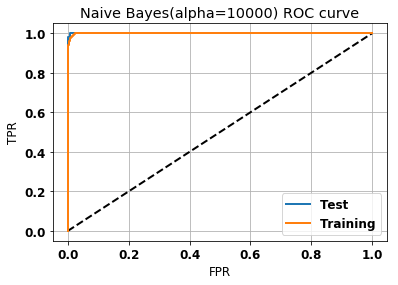

The Training AUC score for hypertuned parameter alpha = 0.0001 is 0.9994365031672069
The Test AUC score for hypertuned parameter alpha = 0.0001 is 0.9998283998283998


In [58]:
# Fitting the model with best parameters 
lr = linear_model.SGDClassifier(loss='log',alpha=nb_cv.best_params_.get('alpha'))
lr.fit(X_tr,y_tr)

# Calculating training and test predicted probabilities
y_pred_proba_test = lr.predict_proba(X_test)[:,1]
y_pred_proba_tr = lr.predict_proba(X_tr)[:,1]

# Calculating False Positive Rate (FPR) and True Positive Rate (TPR) for obtaining ROC curve
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_proba_test)
fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, y_pred_proba_tr)

# Plotting the ROC curve for Test and training data
plt.plot([0,1],[0,1],'k--',linewidth=2.0)
plt.plot(fpr_test,tpr_test, label='Test',linewidth=2.0)
plt.plot(fpr_tr,tpr_tr, label='Training',linewidth=2.0)
plt.xlabel('FPR')
plt.ylabel('TPR')
pylab.legend(loc='lower right')
plt.title('Naive Bayes(alpha={}) ROC curve'.format(nb_cv.best_params_.get('alpha')))
plt.grid()
plt.show()

#Area under ROC curve
print('The Training AUC score for hypertuned parameter alpha = {} is {}'.format(lr_cv.best_params_.get('alpha'),roc_auc_score(y_tr,y_pred_proba_tr)))
print('The Test AUC score for hypertuned parameter alpha = {} is {}'.format(lr_cv.best_params_.get('alpha'),roc_auc_score(y_test,y_pred_proba_test)))

__Confusion Matrix for training data__

Before we plot the confusion matrix we need to find the optimum threshold such that we get a high TPR and low FPR.  We want to keep False Postive as low as possible.

Therefore we define a parameter TF= TPR*(1-FPR) and we try to maximise it while calculating the optimum threshold.

In [59]:
#https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python

i = np.arange(0,len(tpr_tr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr_tr, index=i),'tpr' : pd.Series(tpr_tr, index = i),
                    '1-fpr' : pd.Series(1-fpr_tr, index = i), 'tf' : pd.Series(tpr_tr*(1-fpr_tr), index = i), 
                    'thresholds' : pd.Series(thresholds_tr, index = i)})

roc.ix[(roc.tf-0).abs().argsort()[:1]]

index=roc['tf'].idxmax()

optimim_threshold=roc['thresholds'].iloc[index]
print(roc.iloc[index])
print(optimim_threshold)

fpr           0.022895
tpr           1.000000
1-fpr         0.977105
tf            0.977105
thresholds    0.512658
Name: 40, dtype: float64
0.5126579342392175


Based on the optimum threshold we calculate the predicted probablity

In [60]:
y_pred = (lr.predict_proba(X_tr)[:,1] >= optimim_threshold)*1
# Now we calculate the threshold value
cf=confusion_matrix(y_tr,y_pred)

Plotting the confusion Matrix

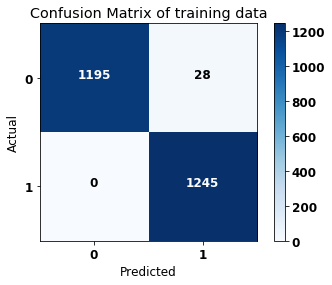

In [61]:
##https://www.kaggle.com/jprakashds/confusion-matrix-in-python-binary-class

plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix of training data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(y_test))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)

# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show();

__Confusion Matrix for test data__

In [62]:
y_pred = (lr.predict_proba(X_test)[:,1] >= optimim_threshold)*1
cf=confusion_matrix(y_test,y_pred)

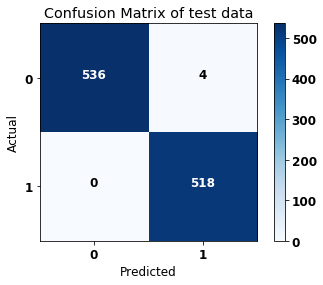

In [63]:
import itertools
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix of test data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(y_test))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show();

__Key Findings on the Logistic Regression Model__

<li> The LR model gives a training ROC AUC score of 0.9994 and the test score is 0.9997.
<li> The LR model greatly improved the training and test score. 
<li> We see that training and test score are comparable. That clearly indicates that we are not overfitting.
<li> The TN and FP are also reduced by the LR as compared to Naive Bayes model.

### Summarizing the results of the classification models

In [64]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model","Test score (ROC AUC)","Cross-Validation score (ROC AUC)","Training score (ROC AUC)"]

x.add_row(["Naive Bayes", 0.7173101673101674, 0.7312593628873694, 0.7383870724106565])
x.add_row(["Logistic Regression",  0.9996246246246246,1, 0.9994463545104375])


print(x)

+---------------------+----------------------+----------------------------------+--------------------------+
|        Model        | Test score (ROC AUC) | Cross-Validation score (ROC AUC) | Training score (ROC AUC) |
+---------------------+----------------------+----------------------------------+--------------------------+
|     Naive Bayes     |  0.7173101673101674  |        0.7312593628873694        |    0.7383870724106565    |
| Logistic Regression |  0.9996246246246246  |                1                 |    0.9994463545104375    |
+---------------------+----------------------+----------------------------------+--------------------------+


# 9. Conclusion

1. Many preprocessing steps such as missing value handling,outlier detection, scaling etc were performed.
2. Many new features were created based on the purchasing behaviour of the customer to perform the customer segmentation
3. DBSCAN was choosen for performing labeling of the custumers on this dataset as it handles noisy data well and it is not baised towards globular shapes.It can well seperate out a high density cluster from a low denstity cluster which is present in our dataset.
4. The dataset was highly imbalanced, we used SMOTE technique to balance the data before performing classification. SMOTE technique prevents overfitting caused by duplication of data points produced by other balancing techniques such as random over sampling. 
5. Since the data set is small, we decided to use simpler model with regularisation such as logistic regression. A simpler model has lesser degrees of freedom compared to number of training observations, thus more robust is the parameter estimatation.
6. Logistic Regression outperform the base model Naive Bayes Model, giving a test score ROC AUC = 0.9996
7. Test, Cross-validation and training score are comparable indicating a low variance in the model.

# 10. Future Work

1. A combination of different models (ensemble modeling) for classification can also be tested for this small dataset to check if it avoids overfitting.
2. A better custumer segmentation can also be performed based on the type of products they buy. For this, NLP can be used to combine similar products together based on their description text.

